In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal # Find peaks in the frequency domain
from scipy.fftpack import fft, fftfreq # Convert to fourier domain, and find the associated frequencies
from statsmodels.tsa.filters.hp_filter import hpfilter # De-trending with Hodrick-Prescott Filter
from statsmodels.nonparametric.smoothers_lowess import lowess # De-trending with LOWESS
from statsmodels.graphics.tsaplots import plot_acf
import pywt

In [4]:
# This is NCES specific, a lot of the code is more generic
df = pd.read_excel('../../data-collection/NCES_data/cleaned_1970-2022.xlsx', header=3, usecols=[0, 2], names=['Year', 'Faculty'])

# Preprocessing
# Delete garbage values
df = df.dropna()
#The first row contains garbage values, so we remove it
df = df.drop(0)

# Convert the data type of 'Year' and 'Faculty' columns to integer
df['Year'] = df['Year'].astype(int)
df['Faculty'] = df['Faculty'].astype(int)

# Convert 'Year' to datetime and set it as the index
df.set_index('Year', inplace=True)

# Ensure the index is datetime and sorted
df.index = pd.to_datetime(df.index, format='%Y')
df = df.sort_index()
df = df.resample('Y').mean()
df['Faculty'] = df['Faculty'].interpolate(method='linear', limit_direction='both')

# Calculate change in faculty (year-over-year change)
df['dFaculty'] = df['Faculty'].diff()
df['dFaculty'] = df['dFaculty'].dropna()

print("\nSummary Statistics:")
print(df['dFaculty'].describe())
print(df['Faculty'].describe())

# print(df)


Summary Statistics:
count       52.000000
mean      9103.980769
std      11085.536282
min      -9000.000000
25%       2558.000000
50%       8741.750000
75%      12697.500000
max      64420.000000
Name: dFaculty, dtype: float64
count        53.000000
mean     597020.933962
std      150020.923003
min      369000.000000
25%      461000.000000
50%      559770.500000
75%      729152.000000
max      843820.000000
Name: Faculty, dtype: float64


C:\Users\sadit\AppData\Local\Temp\ipykernel_10680\2245739886.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df = df.resample('Y').mean()


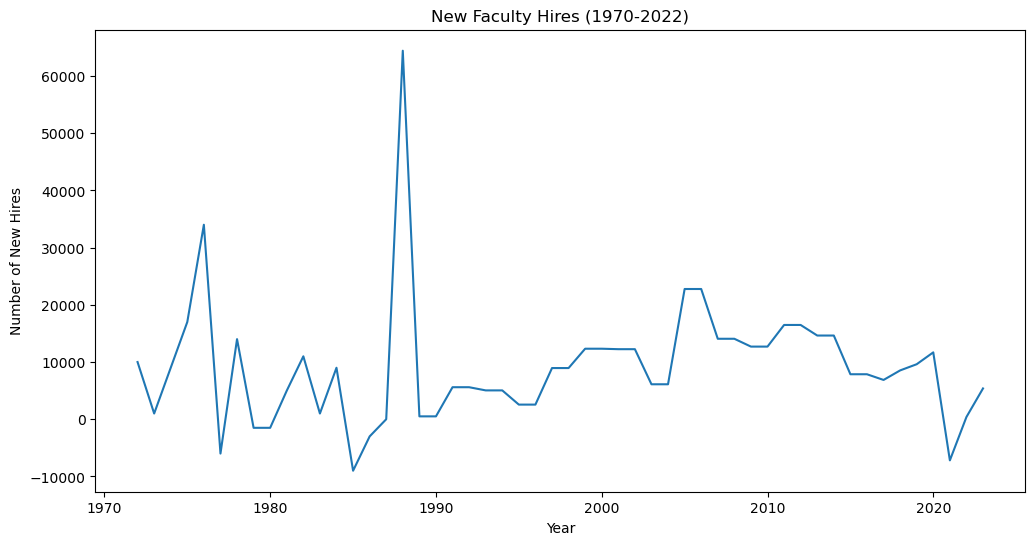

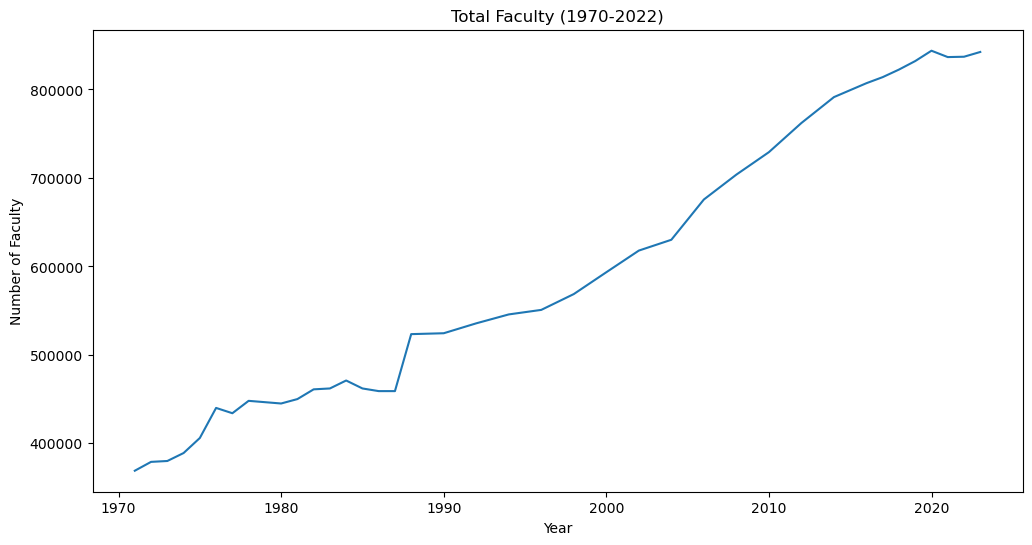

In [5]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['dFaculty'])
plt.title('New Faculty Hires (1970-2022)')
plt.xlabel('Year')
plt.ylabel('Number of New Hires')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Faculty'])
plt.title('Total Faculty (1970-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Faculty')
plt.show()

In [6]:
# 1. Trend Removal (Multiple Methods)

# Method A: Simple Differencing 
# Just goes to the second derivative
df['d2_detrended'] = df['dFaculty'].diff().dropna()


# Method B: Hodrick-Prescott Filter
# Lagrangian - least squares + Lagranage constraint second derivative
# Lambda is a penalty for trend acceleration, to smooth it
cycle, trend = hpfilter(df['dFaculty'].dropna(), lamb=6.25)
df['hp_detrended'] = pd.Series(cycle, index=df.index[1:])

# Method C: LOWESS (Locally Weighted Scatterplot Smoothing)
# Effectively takes the nearest q neighboring points to a x_j
# Uses a weight function to reduce weight of points further from x_j
# Fits a smooth polynomial to this subset of the data using least squares
# Produces an estimate of the y_j and uses this "smoothed" version instead
# Powerful because it doesn't assume functional forms
# Unfortunately gets heavily impacted by a high density of outliers
lowess_result = lowess(df['dFaculty'].dropna(), np.arange(len(df['dFaculty'].dropna())), frac=0.3)
df['lowess_trend'] = pd.Series(lowess_result[:, 1], index=df.index[1:])
df['lowess_detrended'] = df['dFaculty'] - df['lowess_trend']

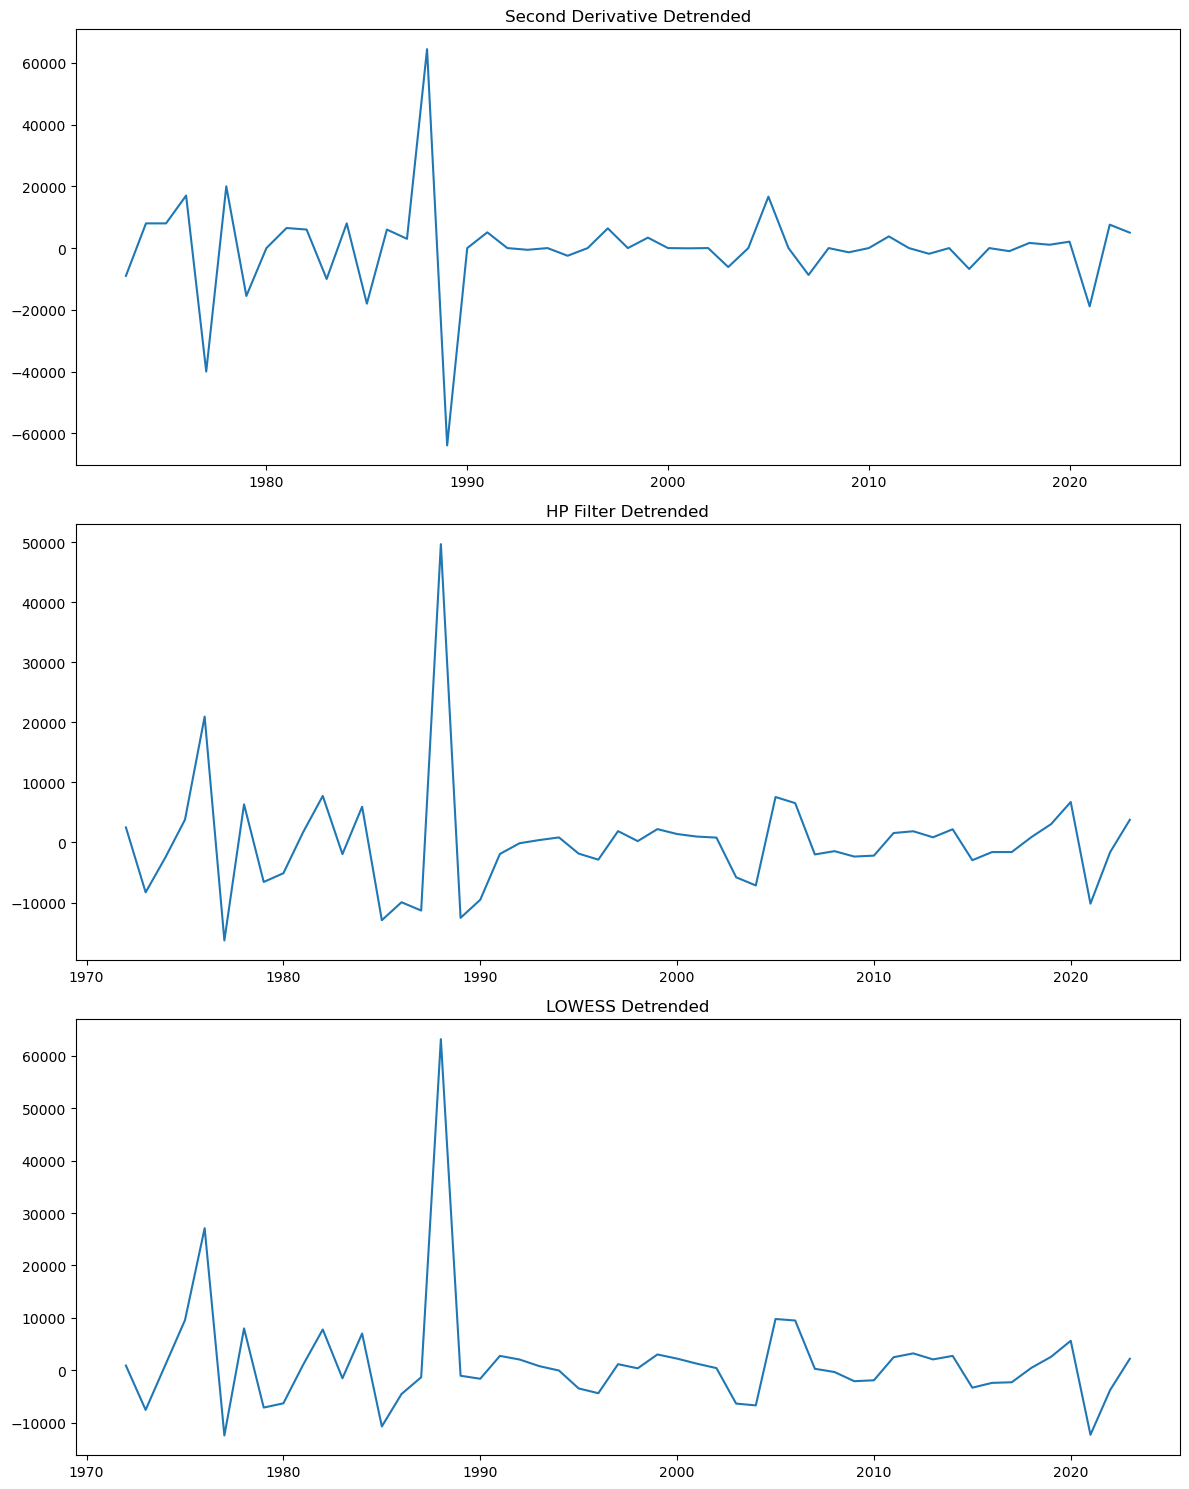

In [7]:
# Plot de-trended data

fig, axes = plt.subplots(3, 1, figsize=(12, 15))
axes[0].plot(df.index[2:], df['d2_detrended'].dropna())
axes[0].set_title('Second Derivative Detrended')
axes[1].plot(df.index[0:], df['hp_detrended'])
axes[1].set_title('HP Filter Detrended')
axes[2].plot(df.index[1:], df['lowess_detrended'].dropna())
axes[2].set_title('LOWESS Detrended')
plt.tight_layout()
plt.show()

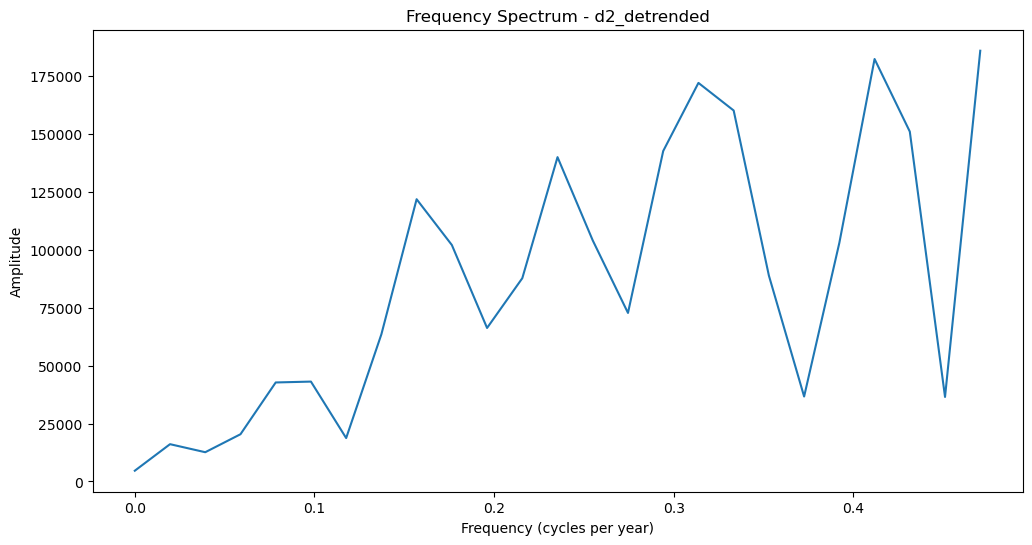


Dominant cycles for d2_detrended:
6.38 years
Relative to maximal amplitude: 0.67.
4.25 years
Relative to maximal amplitude: 0.77.
3.19 years
Relative to maximal amplitude: 0.94.
2.43 years
Relative to maximal amplitude: 1.00.


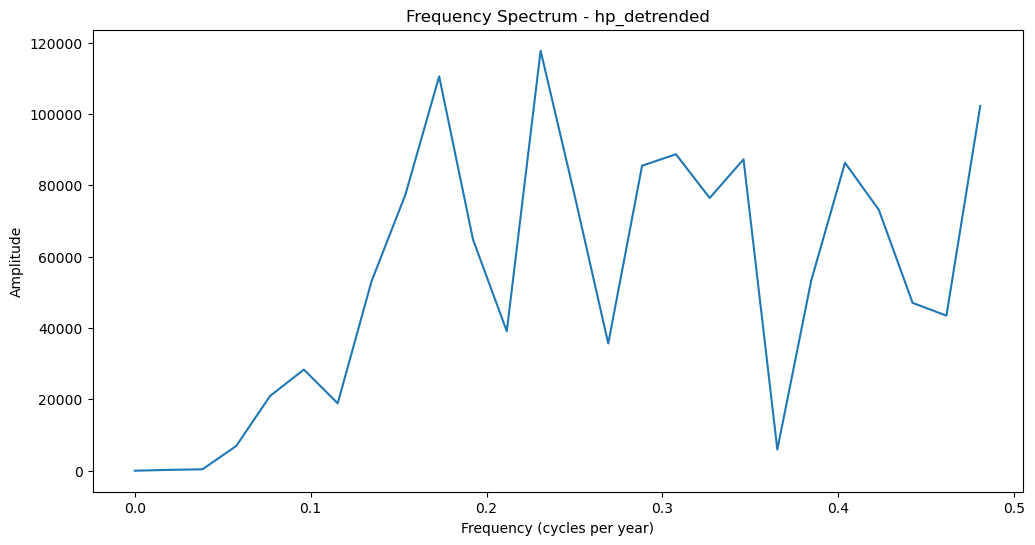


Dominant cycles for hp_detrended:
5.78 years
Relative to maximal amplitude: 0.94.
4.33 years
Relative to maximal amplitude: 1.00.
3.25 years
Relative to maximal amplitude: 0.75.
2.89 years
Relative to maximal amplitude: 0.74.
2.48 years
Relative to maximal amplitude: 0.73.


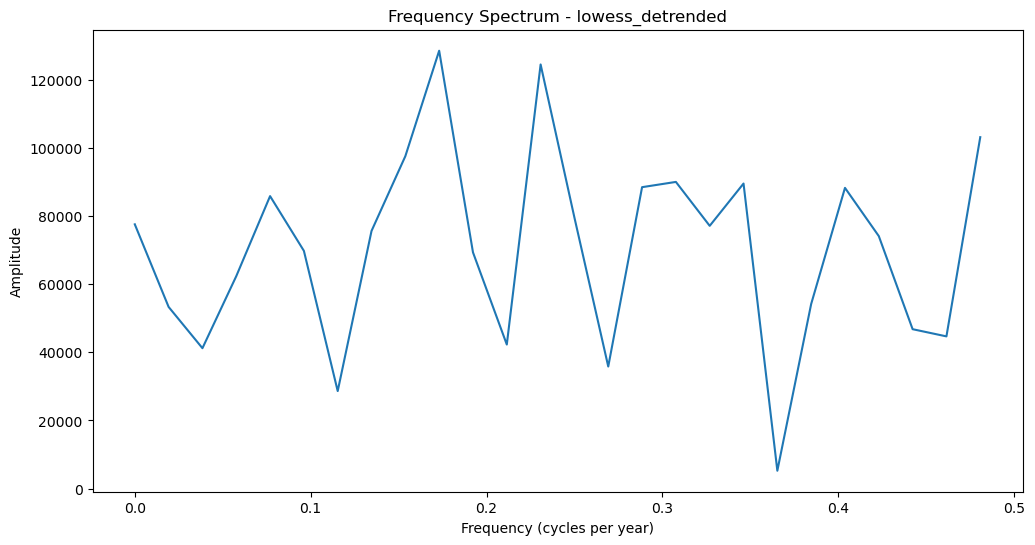


Dominant cycles for lowess_detrended:
13.00 years
Relative to maximal amplitude: 0.67.
5.78 years
Relative to maximal amplitude: 1.00.
4.33 years
Relative to maximal amplitude: 0.97.
3.25 years
Relative to maximal amplitude: 0.70.
2.89 years
Relative to maximal amplitude: 0.70.
2.48 years
Relative to maximal amplitude: 0.69.


In [8]:
# 2. Cyclicality Fourier Analysis

def analyze_cyclicality(series, series_name):
    series = series.dropna()
    # Total time period of obserivation
    T = len(series)
    # Amplitudes of the fourier basis exp(-i 2 pi f t/T)
    # Equivalent to np.sum(x * np.exp(-2j * np.pi * k * np.arange(T)/T))
    fft_result = fft(series.values)
    # f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
    # f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd
    # Just gives us the relevant frequencies with time period d as base unit
    freq = fftfreq(T, d=1)  # Assuming yearly data, so d=1

    # Plot frequency spectrum

    plt.figure(figsize=(12, 6))
    # First half of the coefficients are positive frequency
    # Second half of the coefficients are negative frequency
    # Both halves are related by conjugation since the data is real
    plt.plot(freq[:T//2], np.abs(fft_result)[:T//2])
    plt.title(f'Frequency Spectrum - {series_name}')
    plt.xlabel('Frequency (cycles per year)')
    plt.ylabel('Amplitude')
    plt.show()

    # Find dominant frequencies
    # Literally just finds the peaks in the frequency spectrum data
    peaks, _ = signal.find_peaks(np.abs(fft_result)[:T//2], height=np.std(np.abs(fft_result)[:T//2]))
    amplitudes = np.abs(fft_result)[peaks]
    relative_amplitudes = amplitudes / np.max(amplitudes)
    dominant_freqs = freq[peaks]
    dominant_periods = 1 / dominant_freqs
    
    print(f"\nDominant cycles for {series_name}:")
    for i in range(len(dominant_periods)):
        period = dominant_periods[i]
        rel = relative_amplitudes[i]
        # Filter out high-frequency noise < 1 year periods
        # Filter out very long cycles > T/2
        if period > 1 and period < len(series) / 2: 
            print(f"{period:.2f} years")
            print(f"Relative to maximal amplitude: {rel:.2f}.")

# Analyze cyclicality for each detrended series
for column in ['d2_detrended', 'hp_detrended', 'lowess_detrended']:
    analyze_cyclicality(df[column].dropna(), column)


<Figure size 1200x400 with 0 Axes>

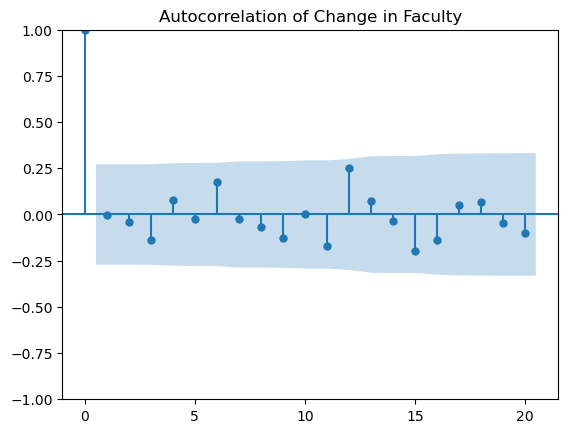

In [9]:
# 3. Autocorrelation Analysis
plt.figure(figsize=(12, 4))
plot_acf(df['dFaculty'].dropna(), lags=20)
plt.title('Autocorrelation of Change in Faculty')
plt.show()

Seems to display 6 and 12 year correlation lengths. Wondering if the length of bargaining contracts has anything to do with this.

## Continuous Wavelet Transform (CWT)

The **Continuous Wavelet Transform (CWT)**  decomposes the signal into wavelets—functions that are localized in both time and frequency.

### Definition

The CWT of a signal \( f(t) \) is defined as:

$C(\tau, t_0) = \frac{1}{\sqrt{|\tau|}} \int_{-\infty}^{\infty} f(t) \psi^*\left( \frac{t - t_0}{\tau} \right) dt$

Where:

- $\tau$ is the **scale**/time window parameter, which controls the dilation or compression of the wavelet.
-$E$ is the **translation**/start time parameter, which controls the shift of the wavelet in time.
- $\psi(t)$ is the **mother wavelet**, some function with relevant properties, preferably easily localizable (like a bump function). Nice to have the family be orthonormal.
- $C(\tau, t_0)$ are the wavelet coefficients, representing the correlation between the signal and wavelets at different scales and positions. Small $\tau$ is sensitive to high frequencies, while large values of $\tau$ give a coarse view of the signal (low frequencies). $t_0$ fixes the starting point of the window of analysis.

### How It Works

- The wavelet transform is computed by taking the **inner product** of the signal and the scaled and translated versions of the mother wavelet. It is useful to use orthonormal projections to simplify the analysis. This explicitly re-encodes the Fourier phase information into a time-frequency representation. Typically, it is useful to have a compact support (a small width in time and frequency), as this makes the wavelet transform computationally efficient, and to have its Fourier transform easily invertible.

- The mother wavelet should have a vanishing integral over all space, to be insensitive to constants. Typically, a vanishing first $m$ moments is preferred to make it sensitive to the $m+1^{th}$ moment. Insensitivity to te first moment deletes linear trends, etc.

$\int_{-\infty}^{\infty} x^j \psi(x) d x = 0,  \quad j = 0, 1, \ldots, m-1$

- The Fourier transform of the mother wavelet should have a finite complex length squared $|\hat{\psi}(\omega)|^2$ , and a finite first order pole at $\omega =0$.



### Inverse CWT

The original signal can be reconstructed from the CWT coefficients through the inverse wavelet transform:

$
f(t) = \frac{1}{C_{\psi}} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} C(\tau, t_0) \psi_{\tau,t_0}(t) \frac{d\tau \, dt_0}{\tau^2}
$

where $ C_{\psi} $ is a constant that depends on the mother wavelet $\psi $, and $\psi_{\tau,t_0}(t)$ is the scaled and translated wavelet.

The CWT provides a flexible and powerful framework for signal analysis, with the ability to adapt to different time-frequency characteristics of the signal.


c:\Users\sadit\miniconda3\envs\erdos-project\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


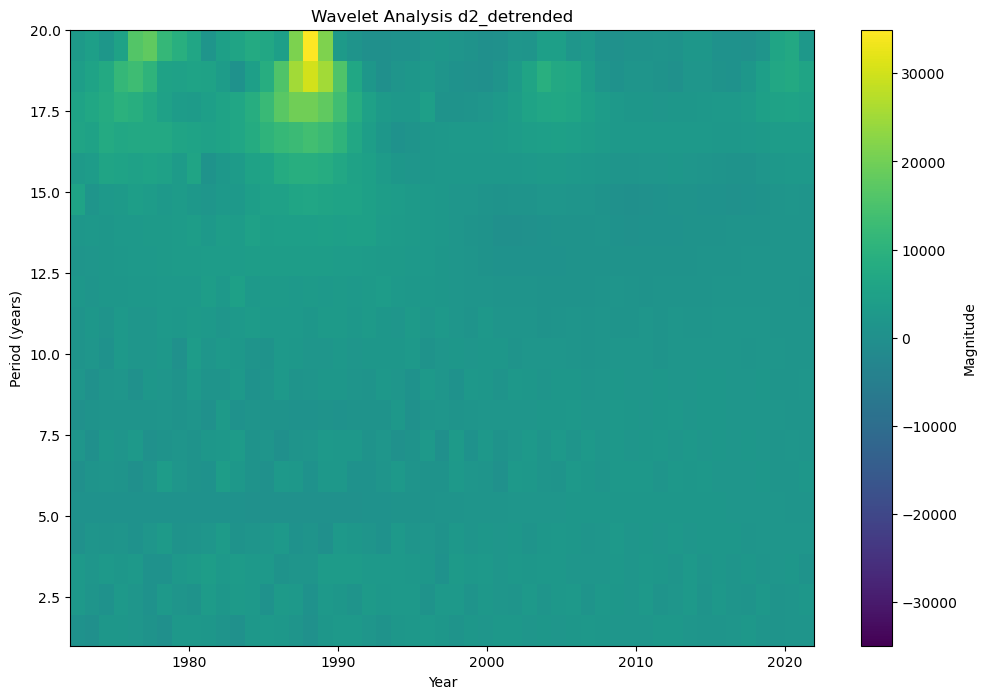

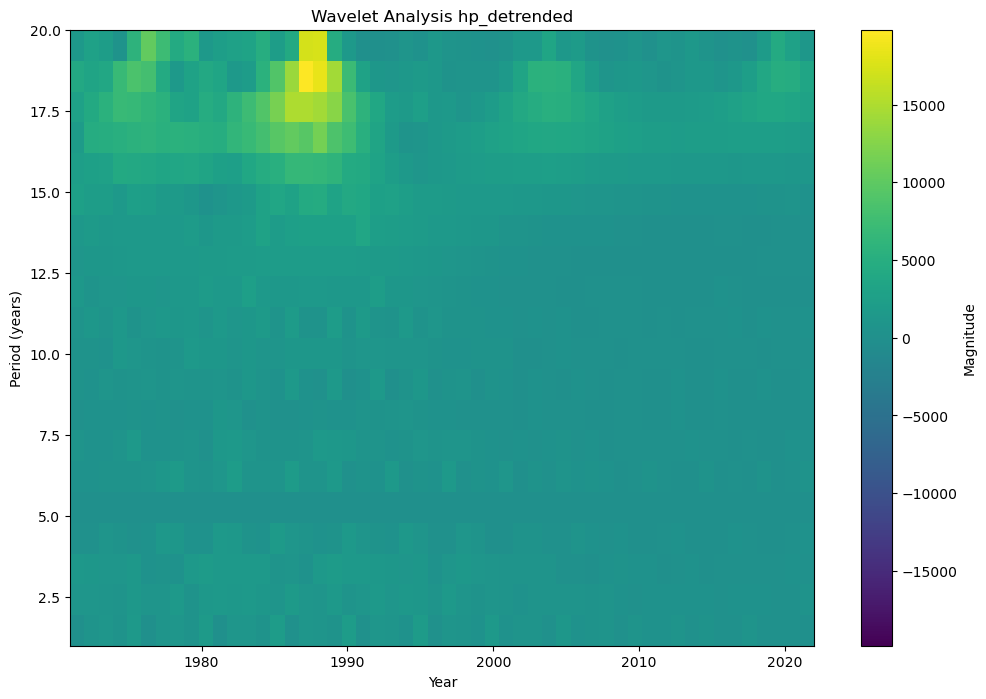

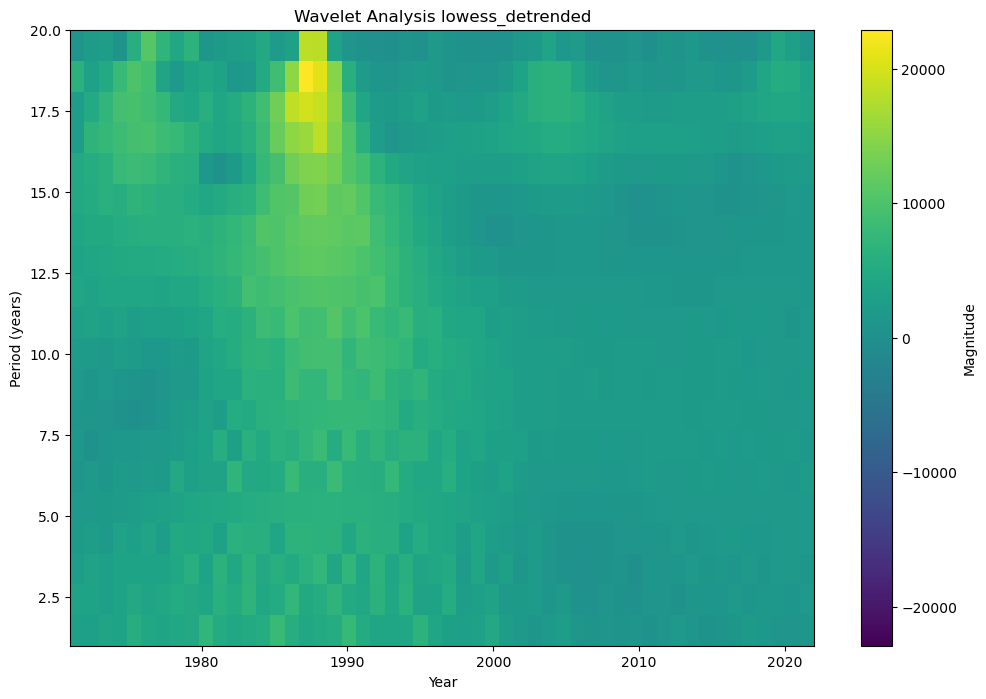

In [10]:
# 4. Wavelet Analysis
# Fourier stuff is good for identifying stationary frequencies
# Wavelet transforms decompose into a frequency vs time plot
# Project the signal function against some mother-wavelet \psi((t-\tau)/E)
# Treat $\psi$ something like a finite support smooth function multiplied by exp(-i \omega t)
# Default wavelet is a complex Morlet (Gaussian-like)

def plot_wavelet(data, scales, wavelet='cmor', title='Wavelet Analysis'):
    data = data.dropna()
    coef, freqs = pywt.cwt(data, scales, wavelet)
    plt.figure(figsize=(12, 8))
    plt.imshow(np.abs(coef), extent=[data.index[0].year, data.index[-1].year, 1, 20], aspect='auto', vmax=abs(coef).max(), vmin=-abs(coef).max())
    plt.colorbar(label='Magnitude')
    plt.ylabel('Period (years)')
    plt.xlabel('Year')
    plt.title(title)
    plt.show()

scales = np.arange(1, 21)
for dataset in ['d2_detrended', 'hp_detrended', 'lowess_detrended']:
    plot_wavelet(df[dataset].dropna(), scales, title='Wavelet Analysis '+dataset) 


Seems like there's a bunch of cyclic hiring in the 70s, but this seems to die out fairly soon. There doesn't seem to be a strong indication of cyclicity in the hiring data here.